<a href="https://colab.research.google.com/github/legardajuanpablo-byte/sp_1_JuanPablo_Legarda.ipynb/blob/main/DegreeProject_DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ===== Instalación de librerías mínimas =====
!pip -q install rasterio geopandas shapely matplotlib

# ===== Librerías =====
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import rasterio, os, time

# ===== Montar Drive =====
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [15]:
# Carpeta base correcta (según tu salida): DataScience_Sentinel1ProjectDegree
BASE = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree')
assert BASE.exists(), f"No existe: {BASE}. Revisa el nombre de la carpeta en tu Drive."

# Buscar bandas (SNAP .img o GeoTIFF .tif) dentro de BASE
def find_bands(base: Path):
    imgs = list(base.rglob('*.img')) + list(base.rglob('*.tif'))
    vv = [p for p in imgs if 'sigma0_vv' in p.name.lower() or '_vv' in p.name.lower()]
    vh = [p for p in imgs if 'sigma0_vh' in p.name.lower() or '_vh' in p.name.lower()]
    return (vv[0] if vv else None), (vh[0] if vh else None)

IMG_VV, IMG_VH = find_bands(BASE)
print("Sigma0_VV:", IMG_VV)
print("Sigma0_VH:", IMG_VH)
assert IMG_VV is not None, "No encontré Sigma0_VV (ni .img ni .tif) dentro de BASE."



Sigma0_VV: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/S1C_IW_GRDH_1SDV_20250726T230637_20250726T230704_003398_006D5D_262B_Orb_Cal_Spk_TC.data/Sigma0_VV.img
Sigma0_VH: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/S1C_IW_GRDH_1SDV_20250726T230637_20250726T230704_003398_006D5D_262B_Orb_Cal_Spk_TC.data/Sigma0_VH.img


In [1]:
# deps ya instaladas: rasterio, matplotlib, numpy
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds

def crop_to_bbox(in_path, out_path, bbox_wgs84, nodata=np.nan):
    """
    Lee SOLO la ventana que cae dentro del bbox (WGS84) y la guarda en GeoTIFF (float32 dB, LZW).
    bbox_wgs84 = (lon_min, lat_min, lon_max, lat_max)
    """
    with rasterio.open(in_path) as src:
        # Llevar bbox al CRS del raster si no está en EPSG:4326
        if src.crs and src.crs.to_string() != "EPSG:4326":
            bbox_src = transform_bounds("EPSG:4326", src.crs, *bbox_wgs84, densify_pts=21)
        else:
            bbox_src = bbox_wgs84

        win = from_bounds(*bbox_src, transform=src.transform).round_offsets().round_lengths()
        arr = src.read(1, window=win).astype("float32")
        # a dB si venía en lineal (>0)
        if np.nanmin(arr) > 0:
            m = np.isfinite(arr)
            arr[m] = 10*np.log10(arr[m])

        meta = src.meta.copy()
        meta.update({
            "driver": "GTiff",
            "height": int(win.height),
            "width": int(win.width),
            "transform": src.window_transform(win),
            "dtype": "float32",
            "nodata": nodata,
            "compress": "LZW",
            "tiled": True,
            "BIGTIFF": "IF_SAFER",
        })

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(arr[np.newaxis, ...])
    return out_path


In [3]:
from pathlib import Path

BASE = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree')

def pick_band(base: Path, key: str):
    cands = list(base.rglob(f'*{key}*.img')) + list(base.rglob(f'*{key}*.tif'))
    if not cands: return None
    # prioriza productos "Orb_Cal_Spk_TC"
    cands.sort(key=lambda p: ('Orb_Cal_Spk_TC' not in str(p), -p.stat().st_mtime))
    return cands[0]

IMG_VV = pick_band(BASE, 'Sigma0_VV') or pick_band(BASE, '_VV')
IMG_VH = pick_band(BASE, 'Sigma0_VH') or pick_band(BASE, '_VH')

assert IMG_VV is not None, "No se encontró Sigma0_VV"
print("VV:", IMG_VV)
print("VH:", IMG_VH)


VV: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/S1C_IW_GRDH_1SDV_20250726T230637_20250726T230704_003398_006D5D_262B_Orb_Cal_Spk_TC.data/Sigma0_VV.img
VH: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/S1C_IW_GRDH_1SDV_20250726T230637_20250726T230704_003398_006D5D_262B_Orb_Cal_Spk_TC.data/Sigma0_VH.img


In [5]:
import numpy as np, rasterio
from pathlib import Path
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds

def crop_to_bbox(in_path, out_path, bbox_wgs84, nodata=np.nan):
    with rasterio.open(in_path) as src:
        bbox_src = transform_bounds("EPSG:4326", src.crs, *bbox_wgs84, densify_pts=21) if src.crs and src.crs.to_string()!="EPSG:4326" else bbox_wgs84
        win = from_bounds(*bbox_src, transform=src.transform).round_offsets().round_lengths()
        arr = src.read(1, window=win).astype("float32")
        if np.nanmin(arr) > 0:  # a dB solo si venía lineal
            m = np.isfinite(arr); arr[m] = 10*np.log10(arr[m])
        meta = src.meta.copy()
        meta.update({"driver":"GTiff","height":int(win.height),"width":int(win.width),
                     "transform":src.window_transform(win),"dtype":"float32",
                     "nodata":nodata,"compress":"LZW","tiled":True,"BIGTIFF":"IF_SAFER"})
    out_path = Path(out_path); out_path.parent.mkdir(parents=True, exist_ok=True)
    with rasterio.open(out_path, "w", **meta) as dst: dst.write(arr[np.newaxis,...])
    return out_path

# BBox compacto CGSM (WGS84)
bbox = (-74.70, 10.60, -74.20, 11.05)

OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
vv_clip = crop_to_bbox(IMG_VV, OUT/'Sigma0_VV_CGSM_dB.tif', bbox)
vh_clip = None
if 'IMG_VH' in globals() and IMG_VH is not None:
    vh_clip = crop_to_bbox(IMG_VH, OUT/'Sigma0_VH_CGSM_dB.tif', bbox)

print("VV →", vv_clip)
print("VH →", vh_clip if vh_clip else "no disponible")



VV → /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs/Sigma0_VV_CGSM_dB.tif
VH → /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs/Sigma0_VH_CGSM_dB.tif


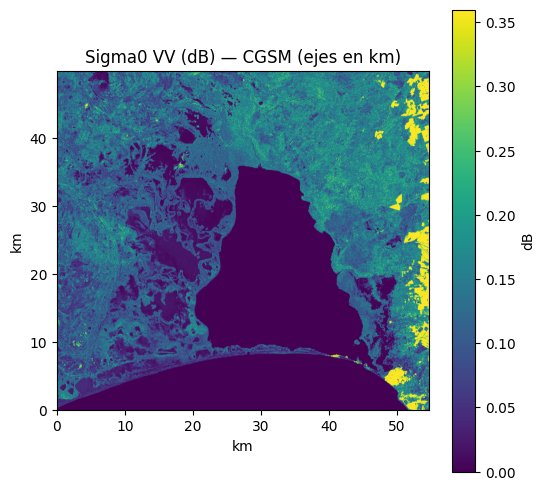

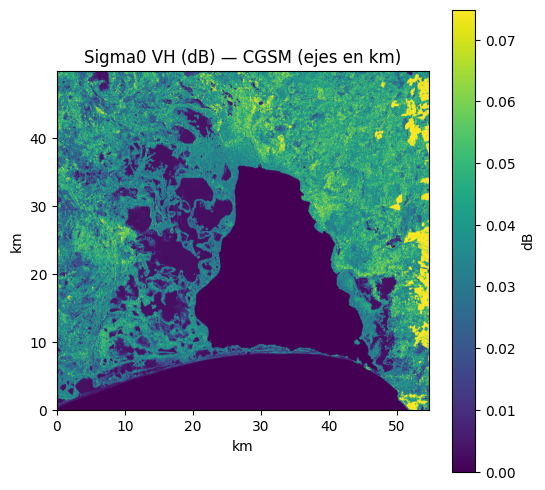

In [20]:
import matplotlib.pyplot as plt
from pyproj import Geod

def extent_km(tif_path):
    with rasterio.open(tif_path) as src:
        left,bottom,right,top = src.bounds
        geod = Geod(ellps="WGS84")
        midlat = (top+bottom)/2; midlon = (left+right)/2
        _,_,width_m  = geod.inv(left,  midlat, right, midlat)   # E–W
        _,_,height_m = geod.inv(midlon,bottom, midlon, top)     # N–S
        return (width_m/1000.0, height_m/1000.0), src.read(1)

# VV
(vv_w_km, vv_h_km), vv_arr = extent_km(vv_clip)

# VH (si existe)
vh_arr, vh_w_km, vh_h_km = None, None, None
if vh_clip:
    (vh_w_km, vh_h_km), vh_arr = extent_km(vh_clip)

# Plot mapas con ejes en km
def show_map(arr, w_km, h_km, title):
    p2, p98 = np.nanpercentile(arr,2), np.nanpercentile(arr,98)
    plt.figure(figsize=(6,6))
    plt.imshow(arr, vmin=p2, vmax=p98, extent=[0, w_km, 0, h_km], origin='lower')
    plt.xlabel("km"); plt.ylabel("km"); plt.title(title)
    cb = plt.colorbar(); cb.set_label("dB"); plt.show()

show_map(vv_arr, vv_w_km, vv_h_km, "Sigma0 VV (dB) — CGSM (ejes en km)")
if vh_arr is not None:
    show_map(vh_arr, vh_w_km, vh_h_km, "Sigma0 VH (dB) — CGSM (ejes en km)")




In [7]:
# ===== Instalación y librerías (mínimas para esta celda) =====
!pip -q install rasterio pyproj pandas

from pathlib import Path
import numpy as np, pandas as pd, rasterio
from pyproj import Geod

# === Rutas de los recortes guardados (ajusta si cambian) ===
VV_PATH = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs/Sigma0_VV_CGSM_dB.tif')
VH_PATH = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs/Sigma0_VH_CGSM_dB.tif')  # opcional

def meta_summary(path: Path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype('float32')
        h, w = src.height, src.width
        b = src.bounds
        crs = src.crs
        # medidas geodésicas (km) y tamaño de píxel (m)
        geod = Geod(ellps='WGS84')
        midlat, midlon = (b.top+b.bottom)/2, (b.left+b.right)/2
        _,_, width_m  = geod.inv(b.left,  midlat, b.right, midlat)
        _,_, height_m = geod.inv(midlon, b.bottom, midlon, b.top)
        px_x_m, px_y_m = width_m/w, height_m/h
        stats = {
            'min_dB': float(np.nanmin(arr)),
            'p25_dB': float(np.nanpercentile(arr,25)),
            'median_dB': float(np.nanpercentile(arr,50)),
            'p75_dB': float(np.nanpercentile(arr,75)),
            'max_dB': float(np.nanmax(arr)),
        }
    meta = {
        'archivo': path.name,
        'filas(px)': h, 'columnas(px)': w, 'pixeles_totales': int(h*w),
        'CRS': str(crs),
        'ancho_km': round(width_m/1000, 3), 'alto_km': round(height_m/1000, 3),
        'px_EW_m': round(px_x_m, 2), 'px_NS_m': round(px_y_m, 2),
    }
    return meta, stats

def sample_center(path: Path, k=5):
    with rasterio.open(path) as src:
        r, c = src.height//2, src.width//2
        r0, r1 = max(0, r-k//2), min(src.height, r+k//2)
        c0, c1 = max(0, c-k//2), min(src.width,  c+k//2)
        arr = src.read(1, window=((r0, r1), (c0, c1)))
    return pd.DataFrame(arr)

# === Estructura y variables ===
rows_meta, rows_vars = [], []

if VV_PATH.exists():
    m_vv, s_vv = meta_summary(VV_PATH)
    rows_meta.append(m_vv)
    rows_vars.append({'variable':'Sigma0_VV','tipo':'numérica continua','unidad':'dB',
                      'min':s_vv['min_dB'],'q25':s_vv['p25_dB'],'mediana':s_vv['median_dB'],
                      'q75':s_vv['p75_dB'],'max':s_vv['max_dB']})

if VH_PATH.exists():
    m_vh, s_vh = meta_summary(VH_PATH)
    rows_meta.append(m_vh)
    rows_vars.append({'variable':'Sigma0_VH','tipo':'numérica continua','unidad':'dB',
                      'min':s_vh['min_dB'],'q25':s_vh['p25_dB'],'mediana':s_vh['median_dB'],
                      'q75':s_vh['p75_dB'],'max':s_vh['max_dB']})

df_estructura = pd.DataFrame(rows_meta)
df_variables  = pd.DataFrame(rows_vars)

print("=== Estructura del dataset (por raster) ===")
display(df_estructura)

print("\n=== Variables clave (rangos en dB) ===")
display(df_variables)

# "head" equivalente: muestra 5x5 del centro (dB)
if VV_PATH.exists():
    print("\nMuestra 5x5 (centro) — Sigma0_VV (dB)")
    display(sample_center(VV_PATH))
if VH_PATH.exists():
    print("\nMuestra 5x5 (centro) — Sigma0_VH (dB)")
    display(sample_center(VH_PATH))


=== Estructura del dataset (por raster) ===


,archivo,filas(px),columnas(px),pixeles_totales,CRS,ancho_km,alto_km,px_EW_m,px_NS_m
0,Sigma0_VV_CGSM_dB.tif,5009,5566,27880094,EPSG:4326,54.676,49.772,9.82,9.94
1,Sigma0_VH_CGSM_dB.tif,5009,5566,27880094,EPSG:4326,54.676,49.772,9.82,9.94



=== Variables clave (rangos en dB) ===


,variable,tipo,unidad,min,q25,mediana,q75,max
0,Sigma0_VV,numérica continua,dB,0.0,0.0,0.093177,0.145248,34.240227
1,Sigma0_VH,numérica continua,dB,0.0,0.0,0.028369,0.041405,4.044678



Muestra 5x5 (centro) — Sigma0_VV (dB)


,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0



Muestra 5x5 (centro) — Sigma0_VH (dB)


,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0


In [8]:
# ===== Librerías mínimas =====
!pip -q install rasterio pandas
import numpy as np, pandas as pd, rasterio
from pathlib import Path

# Rutas de las bandas recortadas
OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
VV_PATH = OUT/'Sigma0_VV_CGSM_dB.tif'
VH_PATH = OUT/'Sigma0_VH_CGSM_dB.tif'  # puede no existir

# Variables clave (numéricas continuas, en dB)
BANDS = []
if VV_PATH.exists(): BANDS.append(("Sigma0_VV", VV_PATH))
if VH_PATH.exists(): BANDS.append(("Sigma0_VH", VH_PATH))

def summarize_band(name, path):
    with rasterio.open(path) as src:
        a = src.read(1).astype('float32')
    tot = a.size
    nans = np.count_nonzero(~np.isfinite(a))
    vals = a[np.isfinite(a)]
    # Conteo de "valores únicos" aproximado (redondeo a 0.1 dB para que sea interpretable)
    uniques_01 = np.unique(np.round(vals, 1)).size if vals.size else 0
    q = lambda p: float(np.nanpercentile(a, p))
    return {
        "variable": name,
        "tipo": "numérica continua",
        "unidad": "dB",
        "pixeles_totales": int(tot),
        "faltantes": int(nans),
        "faltantes_%": round(100*nans/tot, 3),
        "dtype": str(a.dtype),
        "min": float(np.nanmin(a)),
        "p25": q(25), "mediana": q(50), "p75": q(75),
        "max": float(np.nanmax(a)),
        "unicos_(redondeo_0.1dB)": int(uniques_01),
    }

rows = [summarize_band(n, p) for n, p in BANDS]
df_sum = pd.DataFrame(rows)

print("=== Conteo de valores faltantes por variable (ordenado) ===")
display(df_sum.sort_values("faltantes", ascending=False)[
    ["variable","pixeles_totales","faltantes","faltantes_%","dtype"]
])

print("\n=== Conteo de valores únicos (aprox., redondeo 0.1 dB) ===")
display(df_sum[["variable","unicos_(redondeo_0.1dB)"]].sort_values("unicos_(redondeo_0.1dB)", ascending=False))

print("\n=== Estadísticas descriptivas de variables clave (dB) ===")
display(df_sum[["variable","min","p25","mediana","p75","max"]])


=== Conteo de valores faltantes por variable (ordenado) ===


,variable,pixeles_totales,faltantes,faltantes_%,dtype
0,Sigma0_VV,27880094,0,0.0,float32
1,Sigma0_VH,27880094,0,0.0,float32



=== Conteo de valores únicos (aprox., redondeo 0.1 dB) ===


,variable,unicos_(redondeo_0.1dB)
0,Sigma0_VV,211
1,Sigma0_VH,41



=== Estadísticas descriptivas de variables clave (dB) ===


,variable,min,p25,mediana,p75,max
0,Sigma0_VV,0.0,0.0,0.093177,0.145248,34.240227
1,Sigma0_VH,0.0,0.0,0.028369,0.041405,4.044678


In [9]:
# Mínimos
!pip -q install rasterio scikit-image matplotlib

import numpy as np, matplotlib.pyplot as plt, rasterio
from pathlib import Path
from skimage.filters import threshold_otsu

OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
VV_PATH = OUT/'Sigma0_VV_CGSM_dB.tif'
VH_PATH = OUT/'Sigma0_VH_CGSM_dB.tif'

def read_band(p: Path):
    with rasterio.open(p) as src:
        return src.read(1).astype('float32')

vv = read_band(VV_PATH)
vh = read_band(VH_PATH) if VH_PATH.exists() else None
vv_fin = vv[np.isfinite(vv)]


VV convertida a dB: True. Rango dB ~ [-21.8, -3.7]
VH convertida a dB: True. Rango dB ~ [-25.5, -10.7]


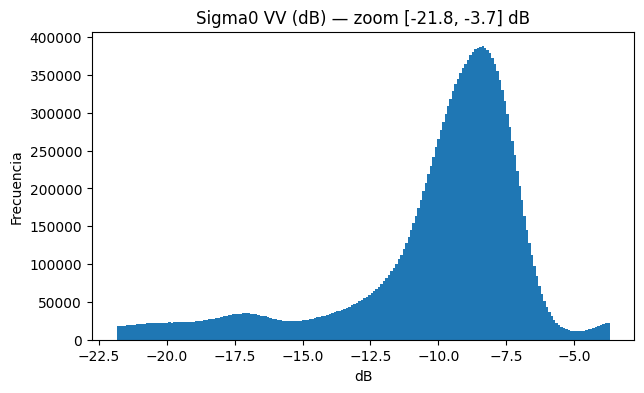

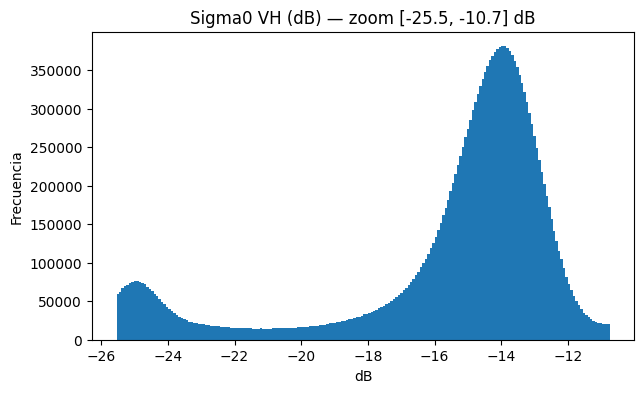

In [19]:
import numpy as np, rasterio, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
VV_PATH = OUT/'Sigma0_VV_CGSM_dB.tif'   # o el recorte que tengas
VH_PATH = OUT/'Sigma0_VH_CGSM_dB.tif'   # puede no existir

def read_band(p):
    with rasterio.open(p) as src:
        return src.read(1).astype('float32')

def to_db_if_needed(a):
    """Convierte a dB si parece lineal (valores en [0,~1.5] y sin negativos).
       Convierte solo donde a>0; deja NaN en no-positivos."""
    a = a.copy()
    p95 = np.nanpercentile(a, 95)
    linear_like = (np.nanmin(a) >= 0) and (p95 <= 1.5)
    if linear_like:
        out = np.full_like(a, np.nan, dtype='float32')
        m = np.isfinite(a) & (a > 0)
        out[m] = 10*np.log10(a[m])
        return out, True
    return a, False

vv = read_band(VV_PATH)
vv_db, conv_vv = to_db_if_needed(vv)
print(f"VV convertida a dB: {conv_vv}. Rango dB ~ [{np.nanpercentile(vv_db,2):.1f}, {np.nanpercentile(vv_db,98):.1f}]")

vh_db, conv_vh = None, None
if VH_PATH.exists():
    vh = read_band(VH_PATH)
    vh_db, conv_vh = to_db_if_needed(vh)
    print(f"VH convertida a dB: {conv_vh}. Rango dB ~ [{np.nanpercentile(vh_db,2):.1f}, {np.nanpercentile(vh_db,98):.1f}]")


def hist_zoom(arr_db, title, logy=False):
    a = arr_db[np.isfinite(arr_db)]
    lo, hi = np.percentile(a, 2), np.percentile(a, 98)
    plt.figure(figsize=(7,4))
    plt.hist(a, bins=200, range=(lo, hi))
    if logy: plt.yscale('log')
    plt.title(f"{title} — zoom [{lo:.1f}, {hi:.1f}] dB")
    plt.xlabel("dB"); plt.ylabel("Frecuencia")
    plt.show()

hist_zoom(vv_db, "Sigma0 VV (dB)", logy=False)
if vh_db is not None:
    hist_zoom(vh_db, "Sigma0 VH (dB)", logy=False)

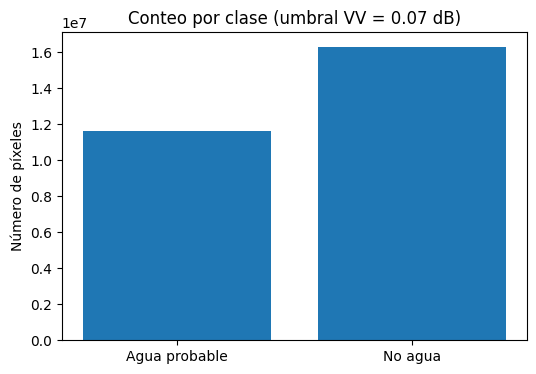

In [11]:
# Umbral automático (Otsu). Si falla por unimodalidad, usa p25 como respaldo.
try:
    thr = float(threshold_otsu(vv_fin))
except Exception:
    thr = float(np.nanpercentile(vv_fin, 25))

cats = np.where(vv <= thr, "Agua probable", "No agua")
n_agua = int(np.sum(cats == "Agua probable"))
n_no   = int(np.sum(cats == "No agua"))

plt.figure(figsize=(6,4))
plt.bar(["Agua probable","No agua"], [n_agua, n_no])
plt.title(f"Conteo por clase (umbral VV = {thr:.2f} dB)")
plt.ylabel("Número de píxeles")
plt.savefig(OUT/"bars_agua_noagua.png", dpi=150, bbox_inches="tight"); plt.show()


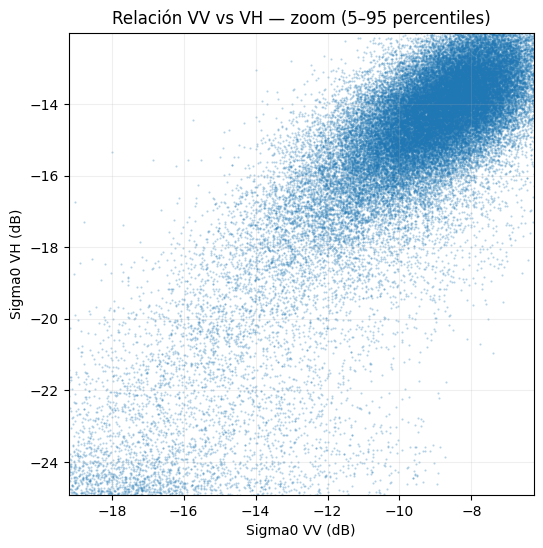

In [21]:
import numpy as np, matplotlib.pyplot as plt

# Usa tus arrays ya cargados: vv, vh  (si ya tienes vv_db/vh_db, reemplázalos abajo)
def to_db(a):
    a = a.astype('float32')
    # si parece lineal (0–~1.5) -> convertir solo donde a>0
    if np.nanmin(a) >= 0 and np.nanpercentile(a,95) <= 1.5:
        out = np.full_like(a, np.nan)
        m = np.isfinite(a) & (a > 0)
        out[m] = 10*np.log10(a[m])
        return out
    return a

vvz = to_db(vv)   # o usa vv_db si ya lo tienes
vhz = to_db(vh)   # o usa vh_db si ya lo tienes

# Muestra ligera y límites por percentiles (zoom)
m = np.isfinite(vvz) & np.isfinite(vhz)
yy, xx = np.where(m)
sel = np.random.default_rng(0).choice(len(xx), size=min(60_000, len(xx)), replace=False)
x = vvz[yy[sel], xx[sel]]
y = vhz[yy[sel], xx[sel]]

xlo, xhi = np.nanpercentile(x, (5, 95))
ylo, yhi = np.nanpercentile(y, (5, 95))

plt.figure(figsize=(6,6))
plt.scatter(x, y, s=0.3, alpha=0.3)
plt.xlim(xlo, xhi); plt.ylim(ylo, yhi)
plt.xlabel("Sigma0 VV (dB)"); plt.ylabel("Sigma0 VH (dB)")
plt.title("Relación VV vs VH — zoom (5–95 percentiles)")
plt.grid(alpha=0.2)
plt.show()


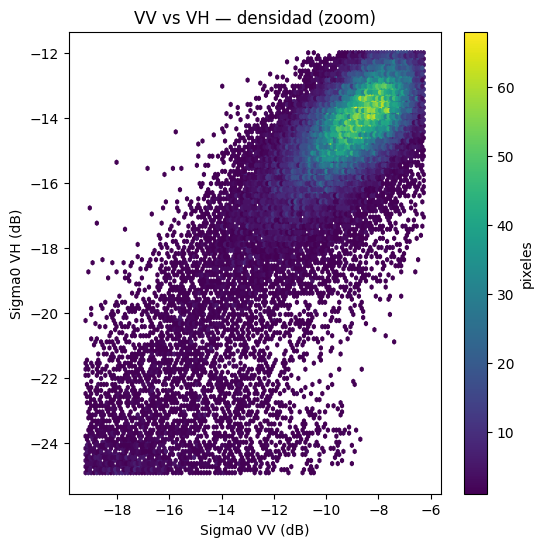

In [22]:
plt.figure(figsize=(6,6))
hb = plt.hexbin(x, y, gridsize=120, extent=[xlo, xhi, ylo, yhi], mincnt=1)
plt.xlabel("Sigma0 VV (dB)"); plt.ylabel("Sigma0 VH (dB)")
plt.title("VV vs VH — densidad (zoom)")
plt.colorbar(hb, label="pixeles")
plt.show()
